
# Perform Customer Clustering for CG based on user portrait and corresponding transactions


In [108]:
# -*- coding: utf-8 -*-
import sys, getopt
import pandas as pd
import datetime
import os
import Tkinter, tkFileDialog
import numpy as np

In [109]:
NOW = pd.to_datetime(datetime.date.today())
inputfile = '/Users/ito/venv/pyspark-rec/data/VijayData.csv'

### Load the data

In [110]:
orders = pd.read_csv(inputfile, sep=',', engine='c', parse_dates=['TimeStamp'])
print orders.shape
orders.head()

(51243, 3)


,UserID,Spent,TimeStamp
0,760,25.0,2009-06-11
1,860,50.0,2012-09-28
2,1200,100.0,2005-10-25
3,1420,50.0,2009-09-07
4,1940,70.0,2013-01-25


* create RFM tables

In [111]:
frequency = orders.groupby('UserID').Spent.agg({'frequency': lambda x: len(x)})
recency = orders.groupby('UserID').TimeStamp.agg({'recency': lambda x: (NOW - x.max()).days})
monetary_value = orders.groupby('UserID').Spent.agg({'monetary_value': lambda x: x.mean()})

/Users/ito/venv/pyspark-rec/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.
/Users/ito/venv/pyspark-rec/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
/Users/ito/venv/pyspark-rec/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


In [112]:
portrait_df = pd.concat([frequency, recency, monetary_value],join="inner",axis=1)
portrait_df.head(5)

,frequency,recency,monetary_value
UserID,,,
10,1.0,4601,30.000000
80,7.0,1145,71.428571
90,10.0,1796,115.800000
120,1.0,2261,20.000000
130,2.0,3772,50.000000


## Perform Customer Clustering
Data Normalization before training process -- Since the distance in sklearn's k-means is euclidean, while we should perform a similarity based clustering (e.g., cosine, PCC, etc.), hence the normalization will make the score of euclidean equalize to cosine -- so to perform similarity based clustering.

In [113]:
from sklearn.preprocessing import normalize

X = np.array(portrait_df)
normed_X = normalize(X, axis=0, norm='l1')
X = normed_X
# pd.DataFrame(X)[[0]].sum()

In [115]:
# XX = np.array(portrait_df)
# XX = normalize(XX, axis=0, norm='l2')
# pd.DataFrame(XX)[[0]].sum()

Suggested by Joc, hereby an elbow method for #cluster selection is conducted. 

Firstly, initialize the plot env.

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# plt.plot()
# colors = ['b', 'g', 'r']
# markers = ['o', 'v', 's']

Perform k-means while tracking their avg clustering distortions.

The “elkan” variation is more efficient by using the triangle inequality.
And it doesn’t support sparse data -- which is good -- our data is dense :)

In [12]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn import metrics

distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k, algorithm='elkan',init='k-means++').fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'cosine'), axis=1)) / X.shape[0])

Plot the elbow according to the distortions from k-means.

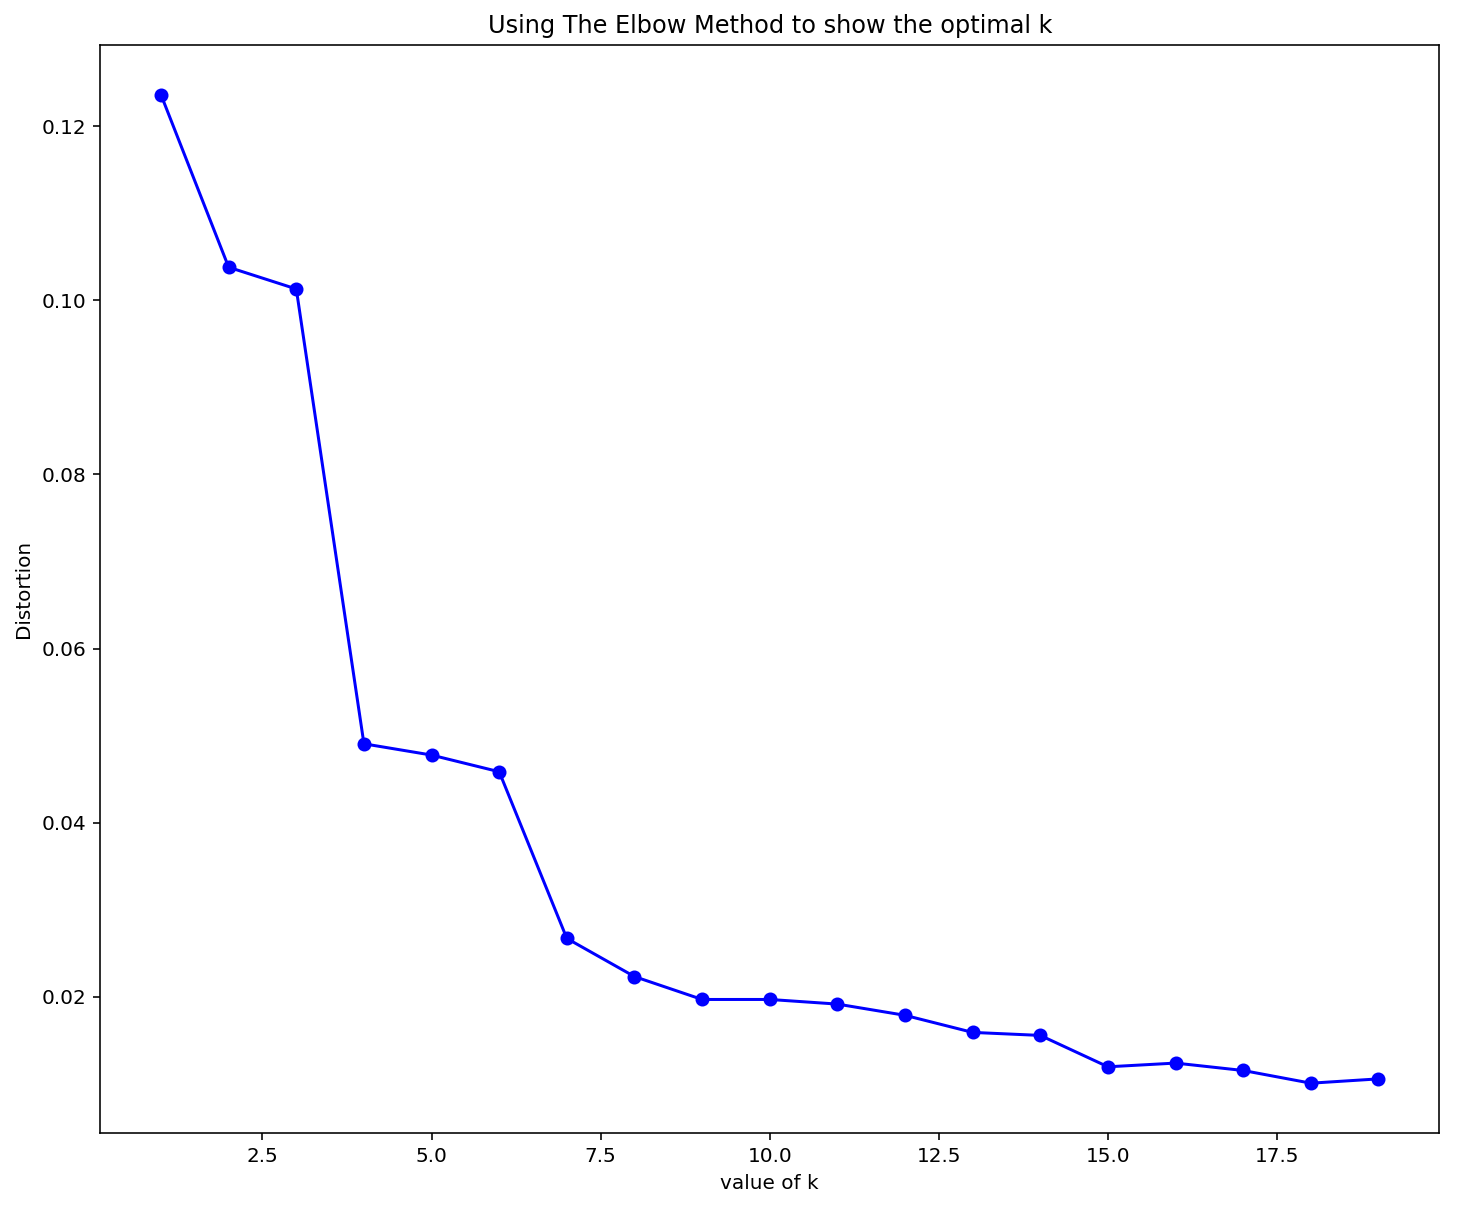

In [13]:
plt.plot(K, distortions, 'bo-')
plt.xlabel('value of k')
plt.ylabel('Distortion')
plt.title('Using The Elbow Method to show the optimal k')
plt.gcf().set_size_inches(12, 10)
plt.show()

At this stage, I would rather choose k = 5 for k, since 5, 6, 7.. share similar performance. Hence let's proceed to analyse when k = 5. 

Also we care about when k = 8.

In [14]:
# from sklearn.cluster import AffinityPropagation
# APModel = AffinityPropagation().fit(X)

## Clusters Analysis

In [16]:
K=8
kmeanModelfinal = KMeans(n_clusters=K, algorithm='elkan').fit(X)

See the number of customers in each cluster.

In [17]:
from collections import Counter
clusters = kmeanModelfinal.labels_.tolist()
clusters_dic = Counter(clusters)
pie_vec = [clusters_dic[i] for i in range(K)]
print pie_vec

[5972, 34, 2357, 186, 8111, 90, 13, 1654]


A pie chart plot to visualize the % for each cluster.

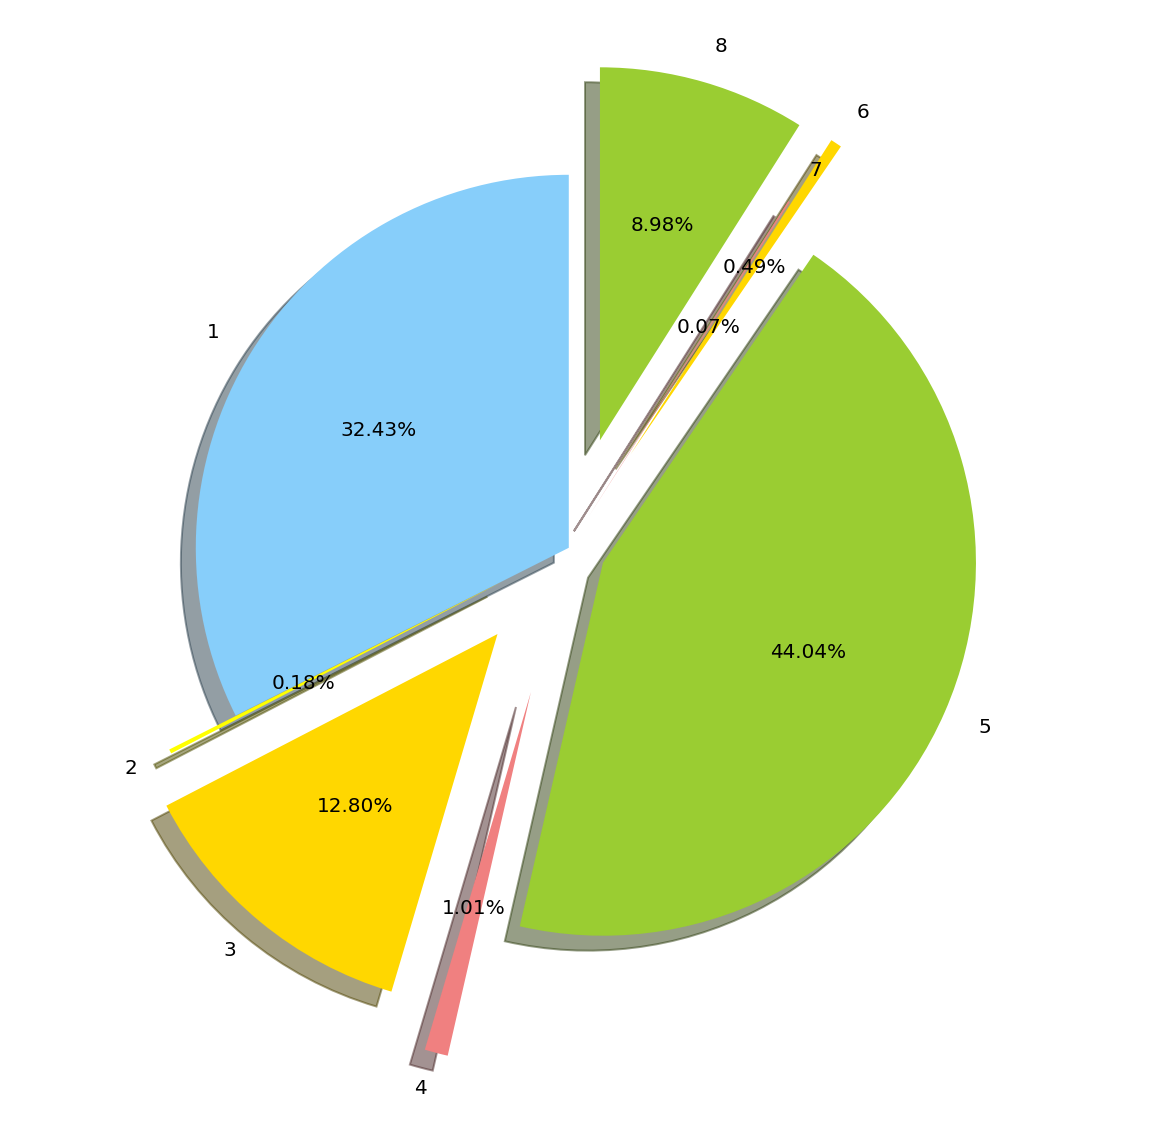

In [18]:
# labels = ['1','2','3','4','5']
labels = ['1','2','3','4','5','6','7','8']
colors = ['lightskyblue', 'yellow', 'gold', 'lightcoral', 'yellowgreen', 'gold', 'lightcoral', 'yellowgreen']
explode = (0, 0.2, 0.3, 0.4, 0.1,0.3, 0.1,0.3)
plt.pie(pie_vec, labels=labels, explode=explode, colors=colors, autopct='%1.2f%%', shadow=True, startangle=90)
plt.gcf().set_size_inches(10, 10)

# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

In [19]:
cluster_df = pd.DataFrame(clusters)
cluster_df.index = portrait_df.index
normalized_df = pd.DataFrame(X)
normalized_df.index = portrait_df.index
frame = pd.concat([portrait_df, normalized_df, cluster_df], axis=1)

In [20]:
frame.columns = ['frequency', 'recency', 'monetary_value', 'norm_frequency', 'norm_recency', 'norm_monetary_value', 'group']
frame.to_csv('VijayDataResult.csv')

* Simply to check the difference between various clusters

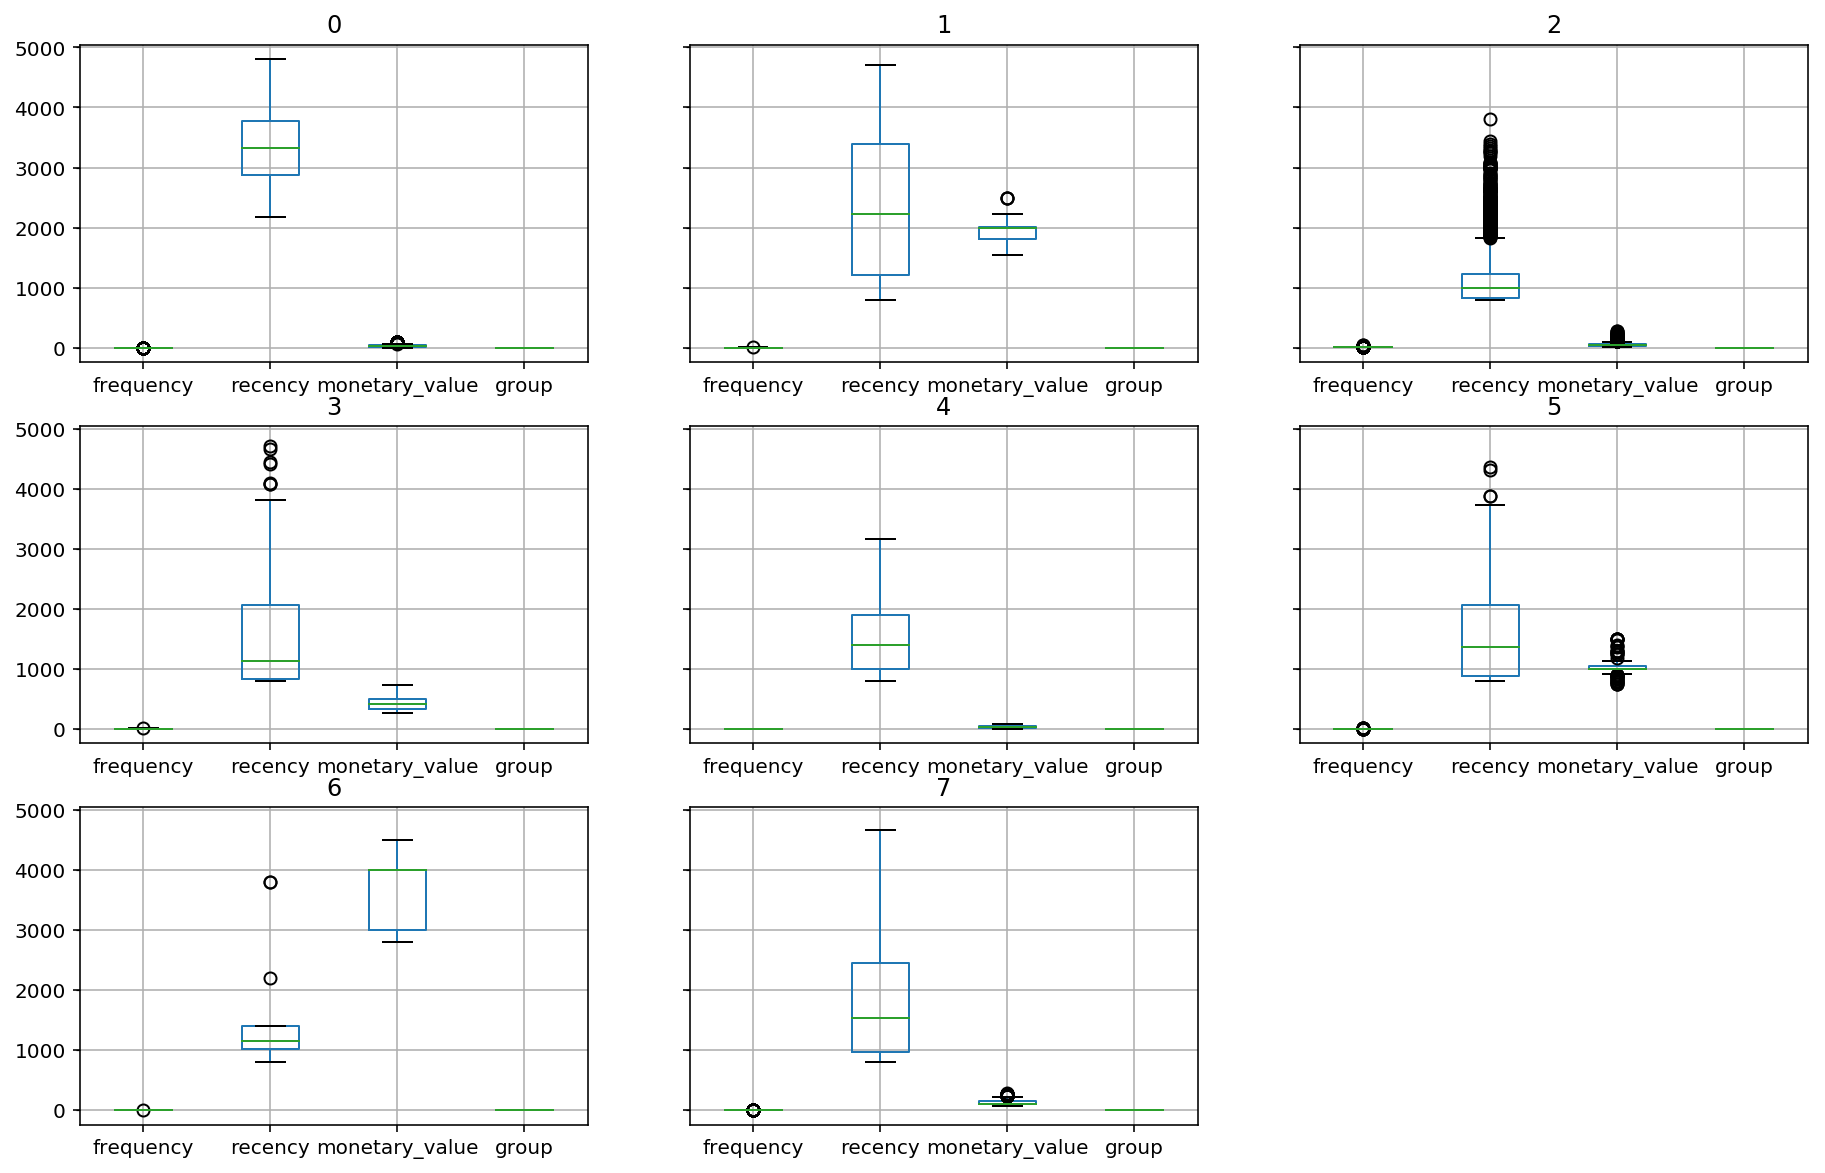

In [97]:
frame[['frequency', 'recency', 'monetary_value','group']].groupby('group').boxplot()
# rfm_amalysis_df[['frequency', 'recency', 'monetary_value']]
plt.gcf().set_size_inches(15, 10)
plt.show()

In [36]:
frame.head()

,frequency,recency,monetary_value,norm_frequency,norm_recency,norm_monetary_value,group
UserID,,,,,,,
10,1.0,4596,30.000000,0.000020,0.000121,0.000028,0
80,7.0,1140,71.428571,0.000137,0.000030,0.000067,2
90,10.0,1791,115.800000,0.000195,0.000047,0.000109,2
120,1.0,2256,20.000000,0.000020,0.000059,0.000019,0
130,2.0,3767,50.000000,0.000039,0.000099,0.000047,0


### budget analysis

* These values below will be set in UI/UX as user input

In [276]:
# total budget for this campaign
budget = 800000
# type of this reward, currently set as cash voucher for illustration, later will also set to cash back %
type_reward = 'cash voucher'
# minimum type of reward
min_reward_amount = 5
# minimum expiration == no expiration
min_reward_exp = 'no expiration'
# switch -- whether all of the consumers have reward
all_distribute = 1

* Summarize the RFM stats for each cluster considered

In [125]:
rfm_amalysis_df = frame.groupby('group').agg({'frequency': lambda x: x.mean(), # Recency
                                              'recency': lambda x: x.mean(),      # Frequency
                                              'monetary_value': lambda x: x.mean()}) # Monetary Value"
rfm_amalysis_df['num_in_group'] = frame.groupby('group').frequency.count()
rfm_amalysis_df['spent'] = frame.groupby('group').monetary_value.sum()
rfm_amalysis_df.sort_values('monetary_value')

,frequency,recency,monetary_value,num_in_group,spent
group,,,,,
0,1.400871,3331.585064,29.307947,5972,175027.056667
4,2.080631,1451.395759,34.615499,8111,280766.316167
2,8.971574,1181.036063,49.343679,2357,116303.050632
7,2.261790,1819.492140,123.517868,1654,204298.554444
3,4.118280,1572.462366,431.924935,186,80338.037866
5,2.722222,1662.477778,1039.724983,90,93575.248463
1,2.147059,2306.676471,1977.099776,34,67221.392381
6,2.307692,1600.769231,3603.365385,13,46843.750000


E.g., all of our customers get reward distributed.

In [280]:
rfm_sort_mv_df = rfm_amalysis_df.sort_values('monetary_value').reset_index()

if all_distribute == 1:
    low_mv_df = rfm_sort_mv_df[rfm_sort_mv_df.monetary_value<frame.monetary_value.mean()]
    high_mv_df = rfm_sort_mv_df[rfm_sort_mv_df.monetary_value>=frame.monetary_value.mean()]
    rest_reward = budget - min_reward * low_mv_df.num_in_group.sum()
    
    ##########################################
    # for those who are below average comsumption
    low_mv_reward = str(1) + ' piece of ' + str(min_reward_amount) + ' dollar ' + type_reward + ', ' + min_reward_exp
    low_mv_df['reward'] = low_mv_reward
    
    ##########################################
    # for those who are above
    high_mv_df['total_reward'] = high_mv_df.monetary_value / high_mv_df.monetary_value.sum() * rest_reward
    high_mv_df['indiv_reward'] = high_mv_df.total_reward / high_mv_df.num_in_group

    high_mv_df['recency'] = high_mv_df.recency - high_mv_df.recency.min()
    high_mv_df = high_mv_df.sort_values('recency')
    high_mv_df['recency'] = high_mv_df.recency / 7 # week

    tickets = 2 / high_mv_df.frequency * high_mv_df.frequency.max() 
    high_mv_df['tickets'] = tickets.map(np.round)


/Users/ito/venv/pyspark-rec/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/ito/venv/pyspark-rec/lib/python2.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/ito/venv/pyspark-rec/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

* A simple algo that returns the number of bits for the figure

In [279]:
def return_bits(input):
    i=0
    input = int(input)
    while 1:
        if input/10 == 0:
            return i
        else:
            input = input / 10
            i = i+1

## According to the consumption behaviour, ppl are segmented to low groups and high groups, where different rewards will be given

In [282]:
low_mv_df

,group,frequency,recency,monetary_value,num_in_group,spent,reward
0,0,1.400871,3331.585064,29.307947,5972,175027.056667,"1 piece of 5 dollar cash voucher, no expiration"
1,4,2.080631,1451.395759,34.615499,8111,280766.316167,"1 piece of 5 dollar cash voucher, no expiration"
2,2,8.971574,1181.036063,49.343679,2357,116303.050632,"1 piece of 5 dollar cash voucher, no expiration"


* According to frequency and recency, we have the following distribution, where
    * frequency controls the number of the vouchers (we encourage lesser frequent consumers)
    * recency controls the expiration of the vouchers (we encourage those 'long time no see' a quick back)
* Monetary value is adapting with return_bits() for rounding issue

In [281]:
reward_for_high = []
for i in range(high_mv_df.shape[0]):
    sub_money = high_mv_df.iloc[i].indiv_reward / high_mv_df.iloc[i].tickets
    reward_for_high.append(str(int(high_mv_df.iloc[i].tickets)) + ' pieces of ' + \
    str(np.round(sub_money, decimals = -return_bits(sub_money))) +\
    ' dollar ' + type_reward + ', ' + str((high_mv_df.shape[0] - i)) + ' weeks of expiration') 
    
high_mv_df['reward'] = pd.Series(data=reward_for_high, index=high_mv_df.group.index)
high_mv_df = high_mv_df[['frequency', 'recency', 'monetary_value','group','num_in_group', 'spent', 'reward']]
high_mv_df

,frequency,recency,monetary_value,group,num_in_group,spent,reward
4,4.118280,0.000000,431.924935,3,186,80338.037866,"2 pieces of 100.0 dollar cash voucher, 5 weeks..."
7,2.307692,4.043838,3603.365385,6,13,46843.750000,"4 pieces of 7000.0 dollar cash voucher, 4 week..."
5,2.722222,12.859345,1039.724983,5,90,93575.248463,"3 pieces of 400.0 dollar cash voucher, 3 weeks..."
3,2.261790,35.289968,123.517868,7,1654,204298.554444,"4 pieces of 2.0 dollar cash voucher, 2 weeks o..."
6,2.147059,104.887729,1977.099776,1,34,67221.392381,"4 pieces of 1000.0 dollar cash voucher, 1 week..."


In [286]:
result_df = pd.concat([low_mv_df,high_mv_df]).sort_values('group')
result_df

,frequency,group,monetary_value,num_in_group,recency,reward,spent
0,1.400871,0,29.307947,5972,3331.585064,"1 piece of 5 dollar cash voucher, no expiration",175027.056667
6,2.147059,1,1977.099776,34,104.887729,"4 pieces of 1000.0 dollar cash voucher, 1 week...",67221.392381
2,8.971574,2,49.343679,2357,1181.036063,"1 piece of 5 dollar cash voucher, no expiration",116303.050632
4,4.118280,3,431.924935,186,0.000000,"2 pieces of 100.0 dollar cash voucher, 5 weeks...",80338.037866
1,2.080631,4,34.615499,8111,1451.395759,"1 piece of 5 dollar cash voucher, no expiration",280766.316167
5,2.722222,5,1039.724983,90,12.859345,"3 pieces of 400.0 dollar cash voucher, 3 weeks...",93575.248463
7,2.307692,6,3603.365385,13,4.043838,"4 pieces of 7000.0 dollar cash voucher, 4 week...",46843.750000
3,2.261790,7,123.517868,1654,35.289968,"4 pieces of 2.0 dollar cash voucher, 2 weeks o...",204298.554444


* The full reward messages for the data frame above

In [287]:
for each in result_df.reward:
    print each

1 piece of 5 dollar cash voucher, no expiration
4 pieces of 1000.0 dollar cash voucher, 1 weeks of expiration
1 piece of 5 dollar cash voucher, no expiration
2 pieces of 100.0 dollar cash voucher, 5 weeks of expiration
1 piece of 5 dollar cash voucher, no expiration
3 pieces of 400.0 dollar cash voucher, 3 weeks of expiration
4 pieces of 7000.0 dollar cash voucher, 4 weeks of expiration
4 pieces of 2.0 dollar cash voucher, 2 weeks of expiration


* Save the file

In [289]:
result_df.to_csv('reward_distributed.csv', index=False)

* Done

In [100]:
# rfm_max_df = frame.groupby('group').agg({'frequency': lambda x: x.max(), 'recency': lambda x: x.max(), 'monetary_value': lambda x: x.max()}) 
# rfm_min_df = frame.groupby('group').agg({'frequency': lambda x: x.min(), 'recency': lambda x: x.min(), 'monetary_value': lambda x: x.min()}) 
# pd.concat([rfm_amalysis_df, rfm_min_df,rfm_max_df],axis=1)

In [98]:
# sub_frame = frame[['frequency', 'recency', 'monetary_value']]
# sub_frame['recency'] = frame.recency - frame.recency.min()
# from sklearn.preprocessing import normalize
# # some = np.array([])
# normed_some = normalize(sub_frame, axis=0, norm='l1')
# pd.DataFrame(normed_some).head()

# K=8
# kmeanModelfinal = KMeans(n_clusters=K, algorithm='elkan').fit(normed_some)
# from collections import Counter
# clusters = kmeanModelfinal.labels_.tolist()
# clusters_dic = Counter(clusters)
# pie_vec = [clusters_dic[i] for i in range(K)]
# print pie_vec

# labels = ['1','2','3','4','5','6','7','8']
# colors = ['lightskyblue', 'yellow', 'gold', 'lightcoral', 'yellowgreen', 'gold', 'lightcoral', 'yellowgreen']
# explode = (0, 0.2, 0.3, 0.4, 0.1,0.3, 0.1,0.3)
# plt.pie(pie_vec, labels=labels, explode=explode, colors=colors, autopct='%1.2f%%', shadow=True, startangle=90)
# plt.gcf().set_size_inches(10, 10)

# # Set aspect ratio to be equal so that pie is drawn as a circle.
# plt.axis('equal')
# plt.show()

In [60]:
# sub_df={}
# for i in range(frame.group.max()+1):
#     sub_df[i] = frame[frame.group == i]

# Temporarily finished here, below are constructing still

# Temporarily finished here, below are constructing still

# Temporarily finished here, below are constructing still

### Cover Tree

In [ ]:
%%bash
pwd

In [ ]:
import scipy
from CoverTree.covertree import *

In [ ]:
ct = CoverTree(X,scipy.spatial.distance.euclidean, leafsize=50, base=2)

In [ ]:
ct._print()

In [ ]:
data2

In [ ]:
data2 = np.array([[0,0], [1.5,2.3], [1.15,2.13], [-1,-1.3], [-1,-1], [50,50]])
ct2 = CoverTree(data2, scipy.spatial.distance.euclidean, leafsize=2, base=2)
ct2._print()

### #####

In [ ]:
def reward_distribution(df, reward_amount, reward_level):
    assert df.group
    

Change the column name for the clustering result.

In [ ]:
frame_column_name = list(frame.columns)
frame_column_name[-1]='cluster'
frame.columns = frame_column_name

In [ ]:
frame = frame.reset_index()
frame.head(2)

In [ ]:
def days_to_year(input):
    try:
        return (NOW - input).days/365
    except:
        return 0
customer['BDay'] = pd.to_datetime(customer['DateofBirth']).dt.date
customer['Age'] = customer.BDay.map(days_to_year)

In [ ]:
customer.head(2)

In [ ]:
Tops_customer = customer[customer.CustomerID.isin(frame.CustomerID)][['CustomerID', "Nationality","Gender","MaritalStatus",'HaveOnlineaccount','Age']]
sorted_Tops_customer = Tops_customer.sort_values('CustomerID')

To better incorporate information, the customer csv file is hence combined with some useful fields.

In [ ]:
# sorted_Tops_customer['CustomerIDR'] = sorted_Tops_customer.CustomerID
# sorted_Tops_customer.head(2)
big_frame = pd.merge(frame, sorted_Tops_customer, how='inner')
# ,left_on=frame.CustomerID, right_on=sorted_Tops_customer.CustomerIDR)

In [ ]:
big_frame.head(2)

### Group Labelling

With the customer clustered, a simple analysis can be hence carried out for an "automated" labelling of the corresponding group/cluster to better understand them. For a better illustration, I have turned different fields to similar [0, 1] scale where all the info can be gathered in one plot.

In [ ]:
import math

def autolabel(rects): 
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/5., 0.025 + height, "%.2f" % float(height))
        
def autolabel_realvalue(rects, realvalues): 
    for idx, rect in enumerate(rects):
        height = rect.get_height()
        plt.text(rect.get_x(), 0.01 + height, "%.4s" % float(realvalues[idx])) #+rect.get_width()/5.
        
def return_log_list(list):
    return [math.log(list[i]) if list[i]>1 else 0 for i in range(len(list)) ]

def normalize_vec(vec):
    v_min, v_max = vec.min(), vec.max() 
    return (vec-v_min)/(v_max-v_min)  

def portionwise(vec):
    return vec / sum(vec)
#     return vec * 1.0 / sum(vec)

In [ ]:
cluster_name_list = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5']
# x =list(range(5)) 
x = np.arange(K)
total_width, n = 0.8, 8 
width = total_width / n  
x = x - (total_width - width) / 2

rects = plt.bar(x,portionwise(list(frame.groupby('cluster').refund.mean())),
                tick_label = cluster_name_list, color = 'gold', width=width, label = 'mean-refund',)
plt.title("Cluster Analysis for each group")

autolabel_realvalue(rects, frame.groupby('cluster').refund.mean())
# autolabel(rects)

rects_2 = plt.bar(x + width, portionwise(list(frame.groupby('cluster').total_spent.mean())),
                  tick_label = cluster_name_list, color = 'lightskyblue', width=width, label='mean-spent') 
# rects_2 = plt.bar(x, return_log_list(frame.groupby('cluster').total_spent.mean()),
#                   tick_label = cluster_name_list, color = 'lightskyblue', width=width, label='mean-spent') 
# autolabel(rects_2)

# for i in range(len(x)):  
#     x[i] = x[i] + width  
rects_2 = plt.bar(x + 2 * width, portionwise(list(frame.groupby('cluster').refund.sum())),
                  tick_label = cluster_name_list, color = 'yellowgreen', width=width, label='total-refund') 
# autolabel(rects_2)
autolabel_realvalue(rects_2, frame.groupby('cluster').refund.sum())

# for i in range(len(x)):  
#     x[i] = x[i] + width  
# rects_3 = plt.bar(x, return_log_list(frame.groupby('cluster').refund.count()),
#                   tick_label = cluster_name_list, color = 'lightcoral', width=width, label='#customer') 
rects_3 = plt.bar(x + 3 * width, portionwise(list(frame.groupby('cluster').frequency.mean())),
                  tick_label = cluster_name_list, color = 'lightcoral', width=width, label='mean-freq') 
# autolabel(rects_3)


# for i in range(len(x)):  
#     x[i] = x[i] + width
localization = list(big_frame.groupby('cluster').Nationality.agg({lambda x: list(x=='Thai').count(True) * 1.0 / len(x)})['<lambda>'])
rects_4 = plt.bar(x + 4 * width, portionwise(localization),
                  color = 'g', width=width, label='localization') 


male = list(big_frame.groupby('cluster').Gender.agg({lambda x: list(x=='M').count(True) * 1.0 / len(x)})['<lambda>'])
female = list(big_frame.groupby('cluster').Gender.agg({lambda x: list(x=='F').count(True) * 1.0 / len(x)})['<lambda>'])

available_gender = np.array(male) + np.array(female)
male_portion = np.array(male) / available_gender
female_portion = np.array(female) / available_gender
total_bar = portionwise(available_gender)
male_section = total_bar * male_portion
female_section = total_bar * female_portion

rects_5 = plt.bar(x + 5 * width, female_section, 
                  color = 'r', width=width, label='female') 
rects_6 = plt.bar(x + 5 * width, male_section,
                  bottom=female_section, color = 'b', width=width, label='male') 

# for i in range(len(x)):  
#     x[i] = x[i] + width
rects_7 = plt.bar(x + 6 * width, portionwise(big_frame.groupby('cluster').Age.std()),
                  color = 'grey', width=width, label='std-age') 


plt.xlabel("Group Indicator")
plt.ylabel("Portionwise level for the fields considered")

plt.legend()
plt.gcf().set_size_inches(16, 10)
plt.show()

### Figure above shows the cluster analysis -- the number above indicating the real value, while all of them are compressed into same scale (portionwise) for visualization only.

In [ ]:
labels = ['least frequent comers',
          '7 Local high-spent customers with most refund record',
          'normal behavior -- should have more vouchers to encourage them',
          'most averaged group, nothing special',
          'nice group in terms of both frequently and spent, while no refunding']
colors = ['lightskyblue', 'green', 'gold', 'lightcoral', 'yellowgreen']

colors[1], colors[0] = colors[0], colors[1]
pie_vec[1], pie_vec[0] = pie_vec[0], pie_vec[1]
labels[1], labels[0] = labels[0], labels[1]

explode = (0, 0.2, 0.3, 0.4, 0.1)
plt.pie(pie_vec, labels=labels, explode=explode, colors=colors, autopct='%1.2f%%', shadow=True, startangle=90)
plt.gcf().set_size_inches(10, 10)
print pie_vec
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

## Correlation Analysis
### The 'frequency', 'valid transaction' and 'varieties' are highly correlated -- means that: come more, shop more and pick more

In [ ]:
# print normalize_vec(np.array(frame.groupby('cluster').valid_trans.mean()))
    
aa = list(frame.groupby('cluster').frequency.mean())
bb = list(frame.groupby('cluster').valid_trans.mean())
cc = list(frame.groupby('cluster').varieties.mean())
print np.corrcoef(aa,bb)[0,1]
print np.corrcoef(bb,cc)[0,1]
print np.corrcoef(aa,cc)[0,1]

In [ ]:
# print normalize_vec(np.array(frame.groupby('cluster').valid_trans.mean()))
    
aa = list(frame.groupby('cluster').total_spent.mean())
bb = list(frame.groupby('cluster').avg_spent.mean())
cc = list(frame.groupby('cluster').med_spent.mean())
print np.corrcoef(aa,bb)[0,1]
print np.corrcoef(bb,cc)[0,1]
print np.corrcoef(aa,cc)[0,1]

In [ ]:
frame.groupby('cluster').total_spent.mean()

In [ ]:
frame.groupby('cluster').refund.mean()

In [ ]:
# for item in frame.groupby('cluster').refund.sum():
    

type(frame.groupby('cluster').refund.sum()[0])

In [ ]:
math.log(1.21)
# frame.groupby('cluster').refund.sum()

### Observation: Current result is with some coarse characteristics for each run-out cluster, however, since the data is biased (as is already a class of customers), current observation is limited. In the near future, we will add hierarchical clustering on top to better define the behavior of customers. 

In [ ]:
kmeanModelfinal_8 = KMeans(n_clusters=8, algorithm='elkan').fit(X)

clusters_8 = kmeanModelfinal_8.labels_.tolist()
clusters_dic_8 = Counter(clusters_8)
pie_vec_8 = [clusters_dic_8[i] for i in range(8)]
print pie_vec_8

labels = ['1','2','3','4','5','6','7','8']
colors = ['lightskyblue', 'yellow', 'gold', 'lightcoral', 'yellowgreen','red','orange','green','blue','black']
# explode = (0, 0.2, 0.3, 0.4, 0.1)
# explode=explode, 
plt.pie(pie_vec_8, labels=labels, colors=colors, autopct='%1.2f%%', shadow=True, startangle=90)
plt.gcf().set_size_inches(10, 10)

# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

In [ ]:
kmeanModelfinal_10 = KMeans(n_clusters=10, algorithm='elkan').fit(X)

clusters_10 = kmeanModelfinal_10.labels_.tolist()
clusters_dic_10 = Counter(clusters_10)
pie_vec_10 = [clusters_dic_10[i] for i in range(10)]
print pie_vec_10

labels = ['1','2','3','4','5','6','7','8','9','10']
colors = ['lightskyblue', 'yellow', 'gold', 'lightcoral', 'yellowgreen','red','orange','green','blue','black']
# explode = (0, 0.2, 0.3, 0.4, 0.1)
# explode=explode, 
plt.pie(pie_vec_10, labels=labels, colors=colors, autopct='%1.2f%%', shadow=True, startangle=90)
plt.gcf().set_size_inches(10, 10)

# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

In [ ]:
[3128, 100, 2, 20, 30, 664, 3, 1, 1, 1049]

## Appendix 

### Data issue to be fixed on

In [ ]:
big_frame.groupby('cluster').Age.min()

Check when the customer IDs are matched -- 
previously solving the case that "big_frame = pd.merge(frame, sorted_Tops_customer, how='inner',                     left_on=frame.index, right_on=sorted_Tops_customer.CustomerID)" is not working.

In [ ]:
def examine_str_match(input1, input2):
    if input1 == input2:
        return 0
    else:
        return 1
    
if sum([examine_str_match(each, sorted_Tops_customer.iloc[idx].CustomerID) for idx, each in enumerate(frame.index)]) == 0:
    print 'test passed'


Plot two stuff on the same page.

In [ ]:
import matplotlib.pyplot as plt

x = range(10)
y1 = [elem*2 for elem in x]
plt.plot(x, y1)

y2 = [elem**2 for elem in x]
plt.plot(x, y2, 'r--')

plt.show()

Just to prove that Agglomerative Clustering is not working on this data set.

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Generate sample data
n_samples = 1500
np.random.seed(0)
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = t * np.cos(t)
y = t * np.sin(t)


X = np.concatenate((x, y))
X += .7 * np.random.randn(2, n_samples)
X = X.T

In [ ]:
# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
knn_graph = kneighbors_graph(X, 30, include_self=False)
sum(sum(knn_graph.nonzero()))*1.0/1500/1500

An example to visualize “Agglomerative clustering with and without structure”

In [ ]:
for connectivity in (None, knn_graph):
    for n_clusters in (30, 3):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(('average', 'complete', 'ward')):
            plt.subplot(1, 3, index + 1)
            model = AgglomerativeClustering(linkage=linkage,
                                            connectivity=connectivity,
                                            n_clusters=n_clusters)
            t0 = time.time()
            model.fit(X)
            elapsed_time = time.time() - t0
            plt.scatter(X[:, 0], X[:, 1], c=model.labels_,
                        cmap=plt.cm.spectral)
            plt.title('linkage=%s (time %.2fs)' % (linkage, elapsed_time),
                      fontdict=dict(verticalalignment='top'))
            plt.axis('equal')
            plt.axis('off')

            plt.subplots_adjust(bottom=0, top=.89, wspace=0,
                                left=0, right=1)
            plt.suptitle('n_cluster=%i, connectivity=%r' %
                         (n_clusters, connectivity is not None), size=17)


plt.show()

### For James' enquery on nationalities

In [ ]:
len(big_frame[big_frame.Nationality == 'Russian'])

In [ ]:
len(big_frame[big_frame.Nationality == 'Thai'])

In [ ]:
len(Counter(big_frame.Nationality))

In [ ]:
Counter(big_frame.Nationality)

In [ ]:
print frame.groupby('cluster').total_spent.mean()
print (frame.groupby('cluster').total_spent.std())

frame.groupby('cluster').refund.sum()
return_log_list(frame.groupby('cluster').total_spent.std())


#### Scatter Plot

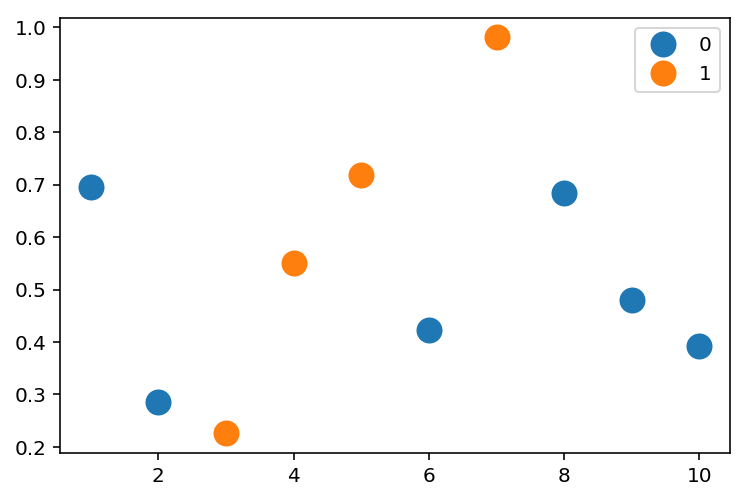

In [288]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(123)

# Generate Data
nbr_dim = 10
y = np.random.random((nbr_dim))
x = [1,2,3,4,5,6,7,8,9,10]
labels = np.random.choice([0, 1], nbr_dim)
df = pd.DataFrame(dict(x=x, y=y, label=labels))

groups = df.groupby('label')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

## Creating the fields as the user portrait -- comprehensive feature engineering

In [ ]:
Tops_trans_df['tDate2'] = pd.to_datetime(Tops_trans_df['TransactionDate']).dt.date
recency = grouped_by_userID.tDate2.agg({'recency': lambda x: (NOW - x.max()).days})

In [ ]:
spent = grouped_by_userID.Spending.agg({'total_spent': np.sum, 'avg_spent': np.mean, 'med_spent': np.median})

In [ ]:
spent_range = grouped_by_userID.Spending.agg({'spent_range': lambda x: x.max()- x.min()})

In [ ]:
frequency = grouped_by_userID.TicketNumber.agg({'frequency': lambda x: len(x)})

In [ ]:
quantities = grouped_by_userID.QTY.agg({'quantities': np.sum})

In [ ]:
from collections import Counter 
varieties = grouped_by_userID.SKUCode.agg({'varieties': lambda x: len(Counter(x))})

In [ ]:
valid = grouped_by_userID.Spending.agg({'valid_trans': np.count_nonzero})
refund = grouped_by_userID.Spending.agg({'refund': lambda x: len(x[x<0])})
# Counter(Tops_trans_df.Spending<0)[True]

In [ ]:
portrait_df = pd.concat([recency, spent, spent_range, quantities, varieties, frequency, valid, refund],join="inner",axis=1)
portrait_df.head(3)